In [7]:
# Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different 
# suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to 
# massive data sets and produces high-quality recommendations in real-time.

In [8]:
# ● userId :Everyuseridentifiedwithauniqueid 
# ● productId :Everyproductidentifiedwithauniqueid
# ● Rating  :Ratingofthecorrespondingproductby the corresponding user
# ● timestamp :Timeoftherating(ignorethiscolumn for this exercise)

In [9]:
# 1. Read and explore the given dataset. (Rename column/add headers, plot histograms, find data characteristics) 

In [10]:
#Loading libraries

%matplotlib inline

import pandas
from sklearn.model_selection import train_test_split
import numpy as np
import time
from sklearn.externals import joblib


import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import re
import seaborn as sns
from surprise import SVD, accuracy
from surprise.model_selection import train_test_split, GridSearchCV

In [11]:
dataFrame = pandas.read_csv("ratings_Electronics.csv")
dataFrame.columns=['UserID','ProductID','Ratings','Timestamp']
dataFrame.shape

(7824481, 4)

In [12]:
dataFrame.head()

,UserID,ProductID,Ratings,Timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [13]:
dataFrame.isnull().sum()

UserID       0
ProductID    0
Ratings      0
Timestamp    0
dtype: int64

In [14]:
dataFrame.dtypes

UserID        object
ProductID     object
Ratings      float64
Timestamp      int64
dtype: object

In [15]:
dataFrame.UserID = dataFrame.UserID.astype('str')
dataFrame.ProductId = dataFrame.ProductID.astype('str')

In [16]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
UserID       object
ProductID    object
Ratings      float64
Timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [17]:
## since we will not require the TimeStamp Column we will delete it
dataFrame.drop(["Timestamp"],axis=1, inplace=True)

In [18]:
dataFrame.head()

,UserID,ProductID,Ratings
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [19]:
print("Shape of Data (Rows,Columns)", dataFrame.shape)
print ("Are there null values in the data:", dataFrame.isnull().values.any())
print("---------------------------------------------")
# find unique Product Id and user Id
print("The total number of Distinct Products are:", dataFrame.ProductID.nunique())
print("The total number of Distinct Users are:", dataFrame.UserID.nunique())

Shape of Data (Rows,Columns) (7824481, 3)
Are there null values in the data: False
---------------------------------------------
The total number of Distinct Products are: 476001
The total number of Distinct Users are: 4201696


In [20]:
dataFrame.dtypes

UserID        object
ProductID     object
Ratings      float64
dtype: object

In [21]:
## distinct values of the Ratings
print("The Distinct Rating Values are: ", dataFrame.Ratings.unique())

The Distinct Rating Values are:  [5. 1. 3. 2. 4.]


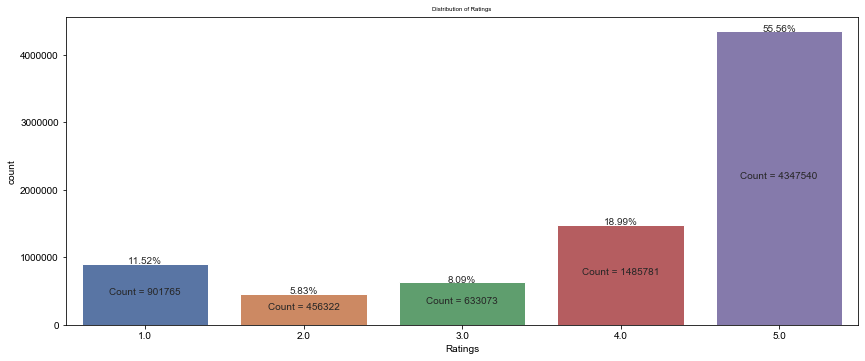

In [22]:
## Visualize the distribution of Ratings:

f,ax = plt.subplots(figsize=(12,5))
sns.set(font_scale=0.5)
ax = sns.countplot(x = "Ratings", data = dataFrame)
my_text  = ax.set_title("Distribution of Ratings")
total = len(dataFrame) # for calculation of percentage

for p in ax.patches:
    #get Height of the column
    height = p.get_height()
    X = p.get_x() + p.get_width()/2
    Y = height + 4
    my_text  = ax.text(X, Y, '{:1.2f}%'.format((height/total)*100), ha="center", size=10)
    my_text  = ax.text(X, Y/2, f'Count = {height}', ha="center", size=10)
    plt.tight_layout()

plt.show()

In [23]:
# Looks like a very high proportion of ratings received is either 5 or 4. Next highest count of ratings received is 
# for 1 which is still a very high number (=100000).

# Lets compare the average rating for each product vs the number of people who rated for the product. 
# This will help identify products which have a very high or low rating because of very few ratings received. 
# Those are like outliers.

In [24]:
ratings = pandas.DataFrame(dataFrame.groupby('ProductID')['Ratings'].mean())
ratings['Number_Of_Ratings'] = pandas.DataFrame(dataFrame.groupby('ProductID')['Ratings'].count())
ratings.head()

,Ratings,Number_Of_Ratings
ProductID,,
0321732944,5.000000,1
0439886341,1.666667,3
0511189877,4.500000,6
0528881469,2.851852,27
0558835155,3.000000,1


In [25]:
# Looks like there are a few products with very few ratings received.

Text(0.5, 1.0, 'Distribution of Ratings')

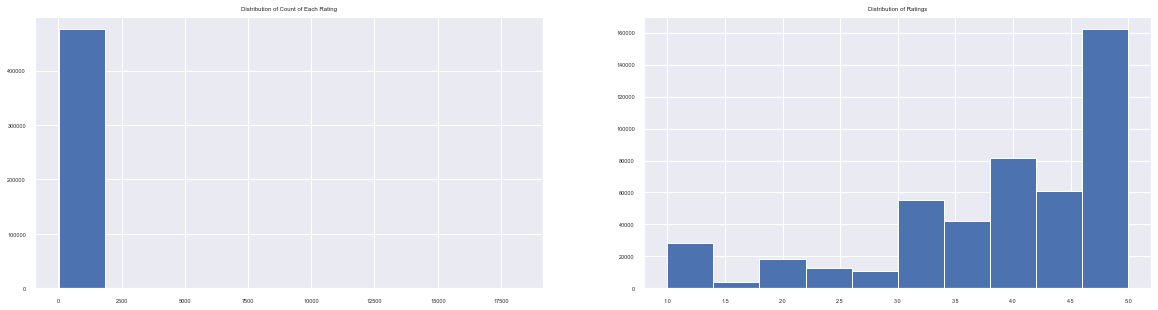

In [26]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(ratings.Number_Of_Ratings)
plt.title('Distribution of Count of Each Rating')

plt.subplot(1,2,2)
plt.hist(ratings.Ratings)
plt.title('Distribution of Ratings')

In [27]:
ratings.describe()

,Ratings,Number_Of_Ratings
count,476001.000000,476001.000000
mean,3.889698,16.437951
std,1.128719,112.702749
min,1.000000,1.000000
25%,3.272727,1.000000
50%,4.000000,2.000000
75%,5.000000,7.000000
max,5.000000,18244.000000


In [28]:
#There seems to be a few outliers for Number of Ratings. The highest value is insanely high.

Q1 = np.percentile(ratings['Number_Of_Ratings'], 25)
Q3 = np.percentile(ratings['Number_Of_Ratings'], 75)
IQR = Q3 - Q1
UL = Q3 + 1.5 * IQR
Outliers = ratings[ratings['Number_Of_Ratings'] > UL]['Number_Of_Ratings']
Outliers.shape

(65660,)

In [29]:
# Most of the ratings are for 5. 3 through to 5 seem to have high density

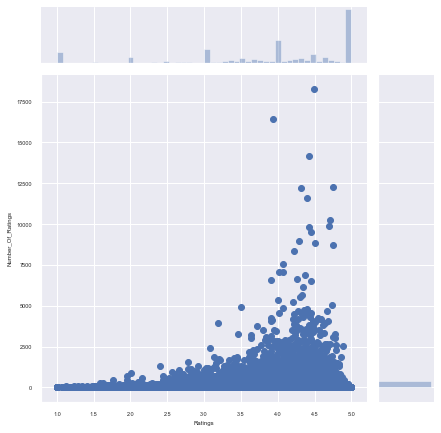

In [30]:
sns.jointplot(ratings.Ratings, ratings.Number_Of_Ratings)

In [31]:
# No great co-relation is noticed. But it is noticeable that products with lower ratings have 
# lesser number of users rating it.

In [32]:
counts = dataFrame.UserID.value_counts()
counts.sort_values(ascending=True).head()

A1KP1JT11L5ICB    1
A3SBRGWNV5NDBK    1
AKX73MTIKU56B     1
A1ZLJ03M2CUQTB    1
A3N6DETPLP9BZ     1
Name: UserID, dtype: int64

In [33]:
# 2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has 
# given 50 or more number of ratings )

In [34]:
# Seems like there a lot of users who have provided very few ratings. Considering the entries from these users 
# may not contribute much to the recommendation system we want to build.
# we keep the users only who has given 50 or more number of ratings

In [35]:
dataFrame = dataFrame[dataFrame['UserID'].isin(counts[counts >= 50].index)]
dataFrame.shape

(125871, 3)

In [36]:
dataFrame.tail()

,UserID,ProductID,Ratings
7824425,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0
7824426,A2NYK9KWFMJV4Y,B00LGQ6HL8,5.0
7824435,A3AYSYSLHU26U9,B00LI4ZZO8,4.0
7824437,A2NYK9KWFMJV4Y,B00LI4ZZO8,5.0
7824443,A2BYV7S1QP2YIG,B00LKG1MC8,5.0


Text(0.5, 1.0, 'Distribution of Ratings')

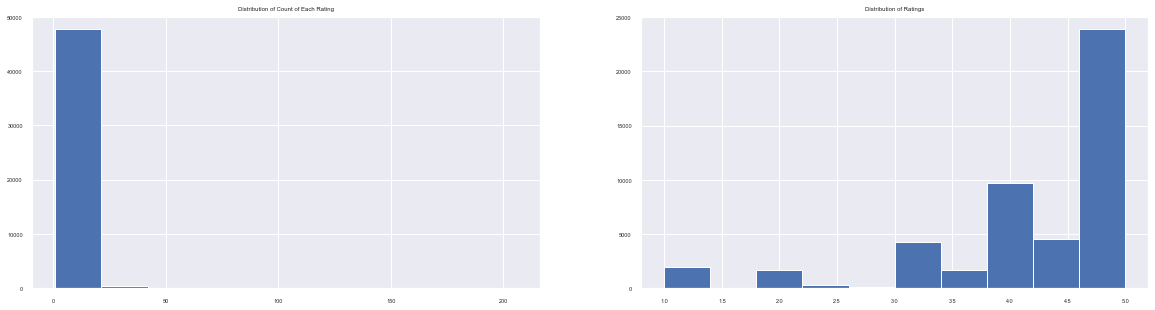

In [37]:
ratings = pandas.DataFrame(dataFrame.groupby('ProductID')['Ratings'].mean())
ratings['Number_Of_Ratings'] = pandas.DataFrame(dataFrame.groupby('ProductID')['Ratings'].count())

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(ratings.Number_Of_Ratings)
plt.title('Distribution of Count of Each Rating')

plt.subplot(1,2,2)
plt.hist(ratings.Ratings)
plt.title('Distribution of Ratings')

In [38]:
# This looks a much better distribution than before, with very high proportion of people having 
# rated products as 4 or 5. However most of the products seem to have been rated only once or twice.

## Recommendation Systems

### Popularity Based Recommendation

* This is not associated to individual User Preference. 
* The recommendation will be based on the entire pool of users and their reactions towards the products.
* For each Product we will identify the distribution of ratings across 5, 4, 3, 2 and 1.
* A 5 Rating for a product indicates greater recommendation by the user and 1 Rating indicates negative recommendation.
* Based on the above principle, we create a scoring formula providing weightage to number of ratings across the 5 rating class and also the total number of ratings that the product received.
* Formula: [(RatingCount5 * 3) + (RatingCount4 * 2) + (RatingCount3 * 1) + (RatingCount2 * -1) + (RatingCount1 * -2)]/[Total Rating for the Product]

In [39]:
# we do a grouping of the products based on their ratings. Essentially we want to identify how many ratings in each class was given 
# for each product out of the total ratings.
test = dataFrame.groupby(["ProductID","Ratings"]).size().reset_index(name='counts')

In [40]:
## We now pivot the data to visualize the distributio of ratings across the 5 classes
df_dist = pandas.pivot(test,index ='ProductID', columns ='Ratings', values = 'counts')
df_dist.tail(5)

Ratings,1.0,2.0,3.0,4.0,5.0
ProductID,,,,,
B00LED02VY,NaN,NaN,NaN,1.0,NaN
B00LGN7Y3G,NaN,NaN,NaN,NaN,1.0
B00LGQ6HL8,NaN,NaN,NaN,NaN,5.0
B00LI4ZZO8,NaN,NaN,NaN,1.0,1.0
B00LKG1MC8,NaN,NaN,NaN,NaN,1.0


In [41]:
df_dist['ProductID'] = df_dist.index

In [42]:
df_dist.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48190 entries, 0594451647 to B00LKG1MC8
Data columns (total 6 columns):
1.0          4469 non-null float64
2.0          4412 non-null float64
3.0          8373 non-null float64
4.0          17526 non-null float64
5.0          32733 non-null float64
ProductID    48190 non-null object
dtypes: float64(5), object(1)
memory usage: 2.6+ MB


In [43]:
## Replace all NaN with 0
df_dist.fillna(0)

Ratings,1.0,2.0,3.0,4.0,5.0,ProductID
ProductID,,,,,,
0594451647,0.0,0.0,0.0,0.0,1.0,0594451647
0594481813,0.0,0.0,1.0,0.0,0.0,0594481813
0970407998,1.0,0.0,0.0,1.0,0.0,0970407998
0972683275,0.0,0.0,0.0,1.0,3.0,0972683275
1400501466,2.0,0.0,1.0,0.0,3.0,1400501466
1400501520,0.0,0.0,0.0,0.0,1.0,1400501520
1400501776,0.0,0.0,0.0,1.0,1.0,1400501776
1400532620,1.0,0.0,0.0,0.0,1.0,1400532620
1400532655,1.0,0.0,1.0,1.0,3.0,1400532655


In [44]:
## matching the counts indicate that the above methods were successfull
df_dist.ProductID.count()
test.ProductID.nunique()

48190

In [45]:
## Scoring Formula Applied
df_dist["total"] = df_dist[1.0] + df_dist[2.0] + df_dist[3.0] + df_dist[4.0] + df_dist[5.0]
df_dist["score"] = ((df_dist[1.0] * -2) + (df_dist[2.0] * -1) + (df_dist[3.0] * 1) 
                    + (df_dist[4.0] * 2) + (df_dist[5.0] * 3))/(df_dist["total"])

## THe scoring formula can be various based on the strategy required. Above formula considers a typical user behaviour of looking at 
## how many top reviews were provided out of the reviews.

In [46]:
## Sorting the values
df_dist = df_dist.sort_values(["score"], ascending=False)

In [47]:
## Based on the score, the following Items can be considered Highly popular
df_dist.head(10)

Ratings,1.0,2.0,3.0,4.0,5.0,ProductID,total,score
ProductID,,,,,,,,
B002V88HFE,1.0,2.0,1.0,20.0,82.0,B002V88HFE,106.0,2.669811
B007WTAJTO,5.0,1.0,3.0,20.0,135.0,B007WTAJTO,164.0,2.664634
B00834SJSK,1.0,1.0,2.0,25.0,72.0,B00834SJSK,101.0,2.623762
B001E1Y5O6,1.0,1.0,3.0,14.0,51.0,B001E1Y5O6,70.0,2.585714
B000JMJWV2,1.0,2.0,1.0,12.0,48.0,B000JMJWV2,64.0,2.578125
B000JE7GPY,1.0,2.0,1.0,8.0,40.0,B000JE7GPY,52.0,2.557692
B001TH7GVE,1.0,1.0,1.0,5.0,27.0,B001TH7GVE,35.0,2.542857
B0058UUR6E,1.0,1.0,1.0,3.0,22.0,B0058UUR6E,28.0,2.500000
B00D1GYNT4,1.0,1.0,1.0,6.0,24.0,B00D1GYNT4,33.0,2.484848


### Collaborative Filtering Based Recommendation

In [48]:
# This is based on the fact that users are grouped based on similar rating patterns and assumption is that 
# they would rating future products similarly.. 

# We will try to visualize a matrix where X contains the unique Products and Y contains the unique Users. 
# The grid will have values for ProductXUser as per the rating given by the user for the products. 
# For no Ratings we will use 0.

# Matrix Factorization - If we consider the above matrix as M X N matrix, and then split it into a dot product 
# of 2 matrices of M x K and K x N where K is a arbitrary number (latent factor hyperparameter). K is usually 
# a number lesser than N (hence latent e.g. for 100 Products with 20 As Consumables and 80 as decoration items, 
# k can be 2). 

# The factors generated  will give two matrices which can be used to calculated the probable preference for 
# another product by the same user. In the above example, if a user has an interest in consumable and not 
# decoration items, and if the new product is a consumable, then its better to recommend the product.

# We will use the surprise package and the SVD algorithm for Matrix factorization.


In [49]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125871 entries, 93 to 7824443
Data columns (total 3 columns):
UserID       125871 non-null object
ProductID    125871 non-null object
Ratings      125871 non-null float64
dtypes: float64(1), object(2)
memory usage: 3.8+ MB


In [50]:
dataFrame.head(5)

,UserID,ProductID,Ratings
93,A3BY5KCNQZXV5U,0594451647,5.0
117,AT09WGFUM934H,0594481813,3.0
176,A32HSNCNPRUMTR,0970407998,1.0
177,A17HMM1M7T9PJ1,0970407998,4.0
491,A3CLWR1UUZT6TG,0972683275,5.0


In [51]:
# Number of unique Users
dataFrame.UserID.unique()

array(['A3BY5KCNQZXV5U', 'AT09WGFUM934H', 'A32HSNCNPRUMTR', ...,
       'AT53ZTTO707MB', 'A1X3ESYZ79H59E', 'A328S9RN3U5M68'], dtype=object)

In [52]:
# Number of unique products
dataFrame.ProductID.unique()

array(['0594451647', '0594481813', '0970407998', ..., 'B00LGQ6HL8',
       'B00LI4ZZO8', 'B00LKG1MC8'], dtype=object)

## Algorithms for Collaborative Filtering 

In [53]:
# We will first split the data into train and test.

In [54]:
# there is difference in between the train_test_split method from Suprise package compared to model_Selection
# Since we are using Surprise package, I am using the train test split from the same package.
from surprise import Reader
from surprise import Dataset

reader= Reader()
data = Dataset.load_from_df(dataFrame[['UserID', 'ProductID', 'Ratings']], reader)
trainset, testset = train_test_split(data, test_size=.30)

In [55]:
#  Use the Different algorithms on the entire Data Set

from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp

In [56]:
knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=5, verbose=False)

In [57]:
svd_cv = cross_validate(SVD(), data, cv=5, n_jobs=5, verbose=False)

In [58]:
svdpp_cv = cross_validate(SVDpp(), data, cv=5, n_jobs=5, verbose=False)

In [59]:
## Dataframe to store Algorithm Results
algo_res = pandas.DataFrame()

algo_res = algo_res.append({'Name' : "KNN Means" , "RMSE" : round(knnmeans_cv['test_rmse'].mean(),4), 
                            "MAE" : round(knnmeans_cv['test_mae'].mean(),4)} , ignore_index=True)
algo_res = algo_res.append({'Name' : "SVD" , "RMSE" : round(svd_cv['test_rmse'].mean(),4), 
                            "MAE" : round(svd_cv['test_mae'].mean(),4)} , ignore_index=True)
algo_res = algo_res.append({'Name' : "SVDPP" , "RMSE" : round(svdpp_cv['test_rmse'].mean(),4), 
                            "MAE" : round(svdpp_cv['test_mae'].mean(),4)} , ignore_index=True)

In [60]:
## Print the RMSE And MAE for all the Algortihms
algo_res.head(3)

,MAE,Name,RMSE
0,0.7652,KNN Means,1.0630
1,0.7271,SVD,0.9828
2,0.7249,SVDPP,0.9846


In [61]:
# Based on the lowest RMSE and MAE combination, we can see SVD and SVD ++ is better. We will consider SVD++ and
# then use tune the hyperparameters for it.

In [62]:
## Finding the best parameters using Grid Search for SVD.
## Query: How do I choose the starting values of the hyperparameters? Can there by a guidance 
## with respect to values to start with
print('Grid Search...')
param_grid = {'n_epochs': [5, 10, 15], 'lr_all': [0.002, 0.005, 0.008]}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
grid_search.fit(data)

Grid Search...


In [63]:
## We will use the best parameters for the model building on training set using SVD.
print('SVD   - RMSE:', round(grid_search.best_score['rmse'], 4))
print('RMSE =', grid_search.best_params['rmse'])

SVD   - RMSE: 0.986
RMSE = {'n_epochs': 10, 'lr_all': 0.008}


In [64]:
### SVDpp taking too much time for Gridsearch hyper tuning

##grid_search = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=3)
##grid_search.fit(data)

In [65]:
# Using SVD to train the model and Test with Test data

In [66]:
algo = SVD(n_epochs=100, lr_all=0.008)
algo.fit(trainset)
## test with test set
test_pred = algo.test(testset)
print("SVD : Test Set")
accuracy.rmse(test_pred, verbose=True)

SVD : Test Set
RMSE: 1.0002


1.0001972123803338

In [67]:
# RMSE - 1.00208 -> This is higher than the RMSE calculated on the entire data set.

In [68]:
dataFrame.ProductID.unique()

array(['0594451647', '0594481813', '0970407998', ..., 'B00LGQ6HL8',
       'B00LI4ZZO8', 'B00LKG1MC8'], dtype=object)

In [69]:
dataFrame.UserID.unique()

array(['A3BY5KCNQZXV5U', 'AT09WGFUM934H', 'A32HSNCNPRUMTR', ...,
       'AT53ZTTO707MB', 'A1X3ESYZ79H59E', 'A328S9RN3U5M68'], dtype=object)

In [70]:
# Building the Program for Recommmendation
# The Input to the program will be UserId (member of the test set) and this will use the train set to train 
# the model

In [80]:
# Top 5 predictions 
top_n = get_top_n(test_pred, n=5)
top_n

defaultdict(list,
            {'A3EQQHWJ1EEYEU': [('B00005114Z', 5),
              ('B003QHXZM4', 5),
              ('B000LRMS66', 5),
              ('B008COJXHC', 5),
              ('B008XVAVAW', 4.950108479099832)],
             'A3QMJMTLJC34QC': [('B000AY5Y5W', 4.841422596599037),
              ('B0000304ZO', 4.758102742470001),
              ('B000068UY7', 4.7276546998129),
              ('B00005TQ08', 4.696381831757121),
              ('B000OLDG60', 4.591033704164066)],
             'A2RTVGR9B1M600': [('B002Y6CJJ8', 4.93546207740904),
              ('B0000DC643', 4.577010228488309),
              ('B004071ZXA', 4.364732645946873),
              ('B007K9WEFI', 4.188355758716133),
              ('B002NR2NTY', 4.188355758716133)],
             'ABXANRX4GPYRZ': [('B003GR0WGQ', 4.760065650032201),
              ('B001NIZB5M', 4.576734696073802),
              ('B000W8SSXQ', 4.529309951091015),
              ('B000I6P1I2', 4.520786967594305),
              ('B000B59JLU', 4.3800919783689

In [71]:
from collections import defaultdict

In [72]:
def get_top_n(predictions, n=5):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    pred_df = pandas.DataFrame()
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [74]:
## Wrapper function which internally calls the Top Recommendation method and arranges the same into a dataframe
def get_top_reco (count,test_pred):
    top_n = get_top_n(test_pred, n=count)
    pred_df = pandas.DataFrame(columns=["UserId"])
    for uid, user_ratings in top_n.items():
        recommendations = {}
        reco = ""
        for (iid, _) in user_ratings:
            reco = reco + iid + ","
        dict_c={"UserId":uid,"Recommendation": reco }
        pred_df = pred_df.append(dict_c, ignore_index= True)
    return pred_df
 

In [75]:
## Function to use SVD algorithm and train the model generating the entire prediction data frame from the test data.
def generate_test(trainset,testset):
    algo = SVD(n_epochs=100, lr_all=0.005)
    algo.fit(trainset)
        ## test with test set
    test_pred = algo.test(testset)
    print("SVD : Test Set")
    accuracy.rmse(test_pred, verbose=True)
    return test_pred

In [76]:
# Function that takes as input USerid and 
## a) creates a train and test data set and calls function to trains the model using SVD model 
##  ,test the data (using test set) and return the all the recommendations for the Test data set 
## b) Filter  out the recommendation based on the User ID from the Test Data Set.
def find_reco(userid):
    trainset, testset = train_test_split(data, test_size=.30)
    test_pred = generate_test(trainset,testset)
    pred_out = get_top_reco (5,test_pred)
    reco = pred_out["Recommendation"][pred_out["UserId"] == userid ]
    return reco

In [77]:
# Number of unique Users
dataFrame.UserID.unique()

array(['A3BY5KCNQZXV5U', 'AT09WGFUM934H', 'A32HSNCNPRUMTR', ...,
       'AT53ZTTO707MB', 'A1X3ESYZ79H59E', 'A328S9RN3U5M68'], dtype=object)

In [81]:
## Main MEthod
userid = "A3BY5KCNQZXV5U"
reco = find_reco(userid) 
print("Recommendations:" , str(reco))

SVD : Test Set
RMSE: 0.9979
Recommendations: 900    B003VAHYNC,B005FYNSPK,B00BGGDVOO,B009A5204K,B0...
Name: Recommendation, dtype: object


In [82]:
## Main MEthod
userid = "AT09WGFUM934H"
reco = find_reco(userid) 
print("Recommendations:" , str(reco))

SVD : Test Set
RMSE: 0.9969
Recommendations: 885    B003M0NURK,B005CT56F8,B006H06TVG,B008A36R2Y,B0...
Name: Recommendation, dtype: object


In [ ]:
# SUMMARY

In [ ]:
# The total number of Distinct Products are: 476001
# The total number of Distinct Users are: 4201696
# The Ratings values are discrete: 1.0 , 2.0, 3.0 , 4.0 and 5.0.

# All the Products that have less than 50 ratings for building the popularity Based Recommendation model 
# were removed for building the Recommendation model
# We Removed all the Users who have rated 50 or less times in the data set

# Recommendation (Popularity Based)
# A 5 Rating for a product indicates greater recommendation by the user and 1 Rating indicates negative 
# recommendation.
# Since its a Popularity Based Recommendation, the Recommendations donot change with Users

# Collaborative Filtering (Matrix Factorization, Nearest Neighbours)
# SVD was found to be providing lower RMSE and hence was chosen algorithm for building the model.
# GridSearch was used for tuning the hyperparameters for SVD
# Final model was found to provide a RMSE on an Average of 1.0021.
# A function was created which takes UserID as input and responds back with the Recommendations (top 5) for the 
# same based on the Model created using SVD.

